# San Diego, California, US

In [1]:
import xarray as xr
import numpy as np
import glob
import ee

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Define helper functions

In [3]:
from geomed3dv4 import *

In [4]:
def plot_fractality(ax, data):
    from scipy.stats import linregress
    import numpy as np
    import matplotlib.ticker as ticker

    ax.loglog(data.r, data, base=2, label='Calculated')
    ax.set_xlabel('Wavelength, m', fontsize=18)

    ax.axes.get_yaxis().set_visible(False)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    res = linregress(np.log2(data.r), np.log2(data))
    ax.plot(data.r, 2**(res.intercept + res.slope*np.log2(data.r)), 'r', label=f'Fitted R²={res.rvalue**2:.2f}', ls='--')

    ax.legend(fontsize=18)

    fractality = 1000*np.round((3 - (res.slope/2)),1)
    return fractality

#def plot_preview(ax, GEEimage, filename):
#    image = plt.imread(filename)
#    ax.imshow(image, interpolation='bilinear', extent=gee_image2rect(GEEimage, True))
def plot_preview(ax, GEEimage, filename):
    import matplotlib.ticker as ticker

    image = plt.imread(filename)
    ax.imshow(image, interpolation='bilinear', extent=gee_image2rect(GEEimage, True))
    #ax.ticklabel_format(useOffset=False, style='plain')
    ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: int(x/1000)))
    ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: int(x/1000)))
    ax1.set_ylabel('Y, km', fontsize=18)
    ax1.set_xlabel('X, km', fontsize=18)

## Connect to GEE

In [5]:
service_account = 'console@gee-export-308512.iam.gserviceaccount.com'
service_key = '/Users/mbg/gee-export.json'

In [6]:
credentials = ee.ServiceAccountCredentials(service_account, service_key)
ee.Initialize(credentials)

## Define work area and scale

In [7]:
# define center of work area, [m]
point = [575500, 3642500]
# radius, [m]
radius = 500
# scale, [m]
scale = 30
# EPSG code (coordinates system)
epsg = 26911

# redefine library function for projected coordinates
def gee_image2rect(GEEimage, reorder=False):
    if not reorder:
        return [point[0]-radius, point[1]-radius, point[0]+radius, point[1]+radius]
    else:
        return [point[0]-radius, point[0]+radius, point[1]-radius, point[1]+radius]

# define spatial components 1*scale .. N*scale [m]
gammas = np.arange(1, 6)

#(minx, miny, maxx, maxy)
GEEarea_proj = ee.Geometry.Rectangle(
        coords=gee_image2rect(None),
        proj=f'EPSG:{epsg}',
        geodesic=False
    )
GEEarea_proj.getInfo()

{'geodesic': False,
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:26911'}},
 'type': 'Polygon',
 'coordinates': [[[575000, 3642000],
   [576000, 3642000],
   [576000, 3643000],
   [575000, 3643000],
   [575000, 3642000]]]}

## Prepare image bands

In [8]:
# https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V3_2
GEEdsm = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").mosaic().select('DSM')

## Build image mosaic

In [9]:
GEEimage = \
    GEEdsm\
    .reproject(crs=f'epsg:{epsg}',scale=scale)
print ('collected bands', GEEimage.bandNames().getInfo())

collected bands ['DSM']


### Make image preview and save on local filesystem
Note: we need to check the image preview quality before the image usage

In [10]:
# define visualization parameters
DEMvis = {'bands':['DSM'], 'min':230, 'max':330,
          'palette': ['00A600','63C600','E6E600','E9BD3A','ECB176','EFC2B3','F2F2F2']}

In [11]:
print (gee_preview_tofile(GEEimage.clip(GEEarea_proj), DEMvis, (320, 320), 'dempreview.320x320.jpg')['url'])

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3e3c2a4f8d877d370ea30d9aca0794f3-d0de21b86d7a255052f6c5684c72fe60:getPixels


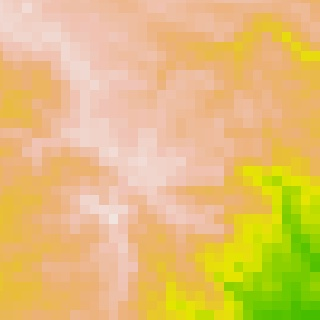

In [12]:
Image('dempreview.320x320.jpg')

### Extract raw image bands and save on local filesystem

In [13]:
GEEurl = GEEimage.getDownloadURL({'filePerBand':True, 'scale': scale, 'region': GEEarea_proj})
print (f'downloading', GEEurl)
fname = f'image.{scale}m.zip'
geeurl_tofile(GEEurl, fname)

downloading https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48776ac70f198813117ce8123809e53f-9f8067261ff15754e2921eb70d81a341:getPixels


### Convert downloaded zipped images chunks to compressed NetCDF file

In [14]:
%%time
ds = zipsbands2image(glob.glob(f'image.{scale}m.zip'))

CPU times: user 76.9 ms, sys: 24.3 ms, total: 101 ms
Wall time: 119 ms


In [15]:
# check data variables
for varname in ds.data_vars:
    print (varname, float(ds[varname].min()), float(ds[varname].max()))

DSM 242.0 325.0


In [16]:
encoding = {var: dict(zlib=True, complevel=6) for var in ds.data_vars}
ds.to_netcdf(f'image.{scale}m.nc', encoding=encoding)
print (ds.dims)

Frozen(SortedKeysDict({'y': 34, 'x': 34}))


## DEM Fractality

In [17]:
dem_power = xr.DataArray([raster_gamma_range(ds.DSM, g-1, g+1, backward=True).std() for g in gammas],
                          coords=[scale*gammas],
                          dims=['r'])

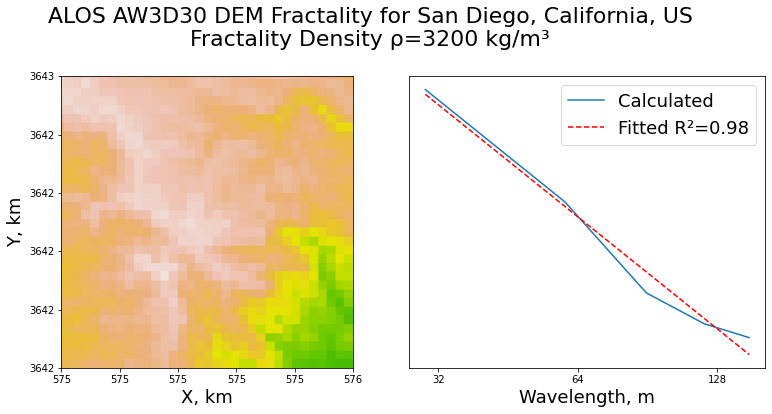

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_preview(ax1, GEEimage, 'dempreview.320x320.jpg')
dem_fractality = plot_fractality(ax2, dem_power)

plt.suptitle(f"ALOS AW3D30 DEM Fractality for San Diego, California, US\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('ALOS AW3D30 DEM Fractality for San Diego, California, US.jpg', dpi=150)
plt.show()